In [79]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [80]:
class Company:
    def __init__(self, founder, \
                 foundation_period = -1,
                 a_coef = random.uniform(0, 0.5), \
                    b_coef = random.uniform(0.75, 1.25), \
                        beta_coef = random.uniform(1.5, 2)):
        # Указываем кто создатель
        self.founder = founder
        # Используем множество поскольку каждый участник является уникальным
        self.members = {founder}
        # Указываем создателю его компанию
        founder.company = self
        self.a = a_coef
        self.b = b_coef
        self.beta = beta_coef
        self.foundation_period = foundation_period

    def output(self, effort, total_effort_prev):
        return self.a * (total_effort_prev + effort) + \
               self.b * (total_effort_prev + effort) ** self.beta
    
class Agent:
    def __init__(self, theta, omega, network, birth_period = -1):
        self.theta = theta
        self.omega = omega
        self.network = network
        self.company = None
        self.effort = 0
        self.utility = 0
        self.birth_period = birth_period

    def choose_effort(self, company, total_effort_prev):
        def utility(effort):
            leisure = self.omega - effort
            team_size = len(company.members)
            if company and company != self.company and team_size == 1:
                consumption = \
                    company.output(effort, total_effort_prev) / team_size
            else:
                consumption = \
                    company.output(effort, total_effort_prev - self.effort) / (team_size - 1) if company and len(company.members) > 1 else 0
            return consumption ** self.theta * leisure ** (1 - self.theta)

        def negative_utility(effort):
            return -utility(effort)

        res = minimize(negative_utility, self.omega / 2, bounds = [(0, self.omega)])
        self.effort = res.x[0]
        self.utility = -res.fun

    def choose_team(self, teams, period):
        #  Вычислить оптимальные усилия и полезность от оптимальных усилий в текущей фирме
        self.choose_effort(self.company, sum(a.effort for a in self.company.members) if self.company else 0)
        current_utility = self.utility
        best_team = self.company
        best_utility = current_utility
        #  Вычислить оптимальные усилия и полезность от оптимальных усилий во вновь создаваемой фирме
        new_team = self.company
        if len(self.company.members) != 1:
            new_team = Company(self, period)
            self.choose_effort(new_team, 0)
            startup_utility = self.utility
            best_utility = max(current_utility, startup_utility)
            if current_utility >= startup_utility:
                best_team = self.company
            else:
                best_team = new_team
            teams[new_team] = new_team

        # Для каждой фирмы в социальной сети агента
        for friend in self.network:
            if friend.company and friend.company != self.company:
                # Вычислить оптимальные усилия и полезность от оптимальных усилий
                other_effort = sum(a.effort for a in friend.company.members)
                self.choose_effort(friend.company, other_effort)
                if self.utility > best_utility:
                    best_utility = self.utility
                    best_team = friend.company

        # Если текущая фирма - не лучший вариант, покинуть ее
        if self.company != best_team:
            if self.company:
                self.company.members.remove(self)
                if not self.company.members:
                    del teams[self.company]
                    
        # Если стартап - лучший вариант: создать стартап
        if best_team == new_team:
            teams[new_team] = new_team
            best_team.members.add(self)

        # Если другая фирма - лучший вариант: присоединиться
        if best_team != new_team and best_team != self.company:
            best_team.members.add(self)

        self.company = best_team

In [81]:
def print_stats(name, data):
    print(f"{name} - Среднее: {np.mean(data):.2f}, Медиана: {np.median(data):.2f}, Мин: {np.min(data):.2f}, Макс: {np.max(data):.2f}")

def plot_distributions(*data, titles=None):
    num_plots = len(data)
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.flatten()

    for i in range(num_plots):
        axs[i].hist(data[i], bins = 20)
        if titles:
            axs[i].set_title(titles[i])
        axs[i].set_xlabel('Значение')
        axs[i].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

def plot_scatter(x, y, xlabel, ylabel, title):
    plt.figure(figsize = (8, 6))
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def show_stats(agents, teams, period, job_changes):
    # Характеристики распределения отдельных показателей
    efforts = [agent.effort for agent in agents]
    output = [agent.company.output(agent.effort, sum(a.effort for a in agent.company.members)) if agent.company else 0 for agent in agents]
    income = [out / len(agent.company.members) if agent.company else 0 for out, agent in zip(output, agents)]
    utility = [agent.utility for agent in agents]
    team_sizes = [len(agent.company.members) if agent.company else 0 for agent in agents]
    team_ages = [period - agent.company.founder.birth_period if agent.company else 0 for agent in agents]

    # Вывод основных характеристик
    print(f"Период: {period}")
    print_stats("Усилия", efforts)
    print_stats("Выпуск", output)
    print_stats("Доход", income)
    print_stats("Полезность", utility)
    print_stats("Размер компании", team_sizes)
    print_stats("Возраст компании", team_ages)

    print(f"Количество агентов: {len(agents)}")
    print(f"Количество команд: {len(teams)}")
    print(f"Средние усилия: {np.mean(efforts):.2f}")
    print(f"Средний выпуск: {np.mean(output):.2f}")
    print(f"Средний доход: {np.mean(income):.2f}")
    print(f"Средняя полезность: {np.mean(utility):.2f}")
    print(f"Количество смен работы: {job_changes}")

    # Гистограммы распределений
    plot_distributions(efforts, output, income, utility, team_sizes, team_ages,
                       titles=["Распределение усилий", "Распределение выпуска", "Распределение дохода",
                               "Распределение полезности", "Распределение размера компании", "Распределение возраста компании"])

    # Взаимосвязь показателей (графики точками)
    plot_scatter(team_ages, team_sizes, "Возраст компании", "Размер компании", "Размер компании vs Возраст компании")

    growth_rates = [len(agent.company.members) / (period - agent.company.founder.birth_period) \
                    if agent.company and period != agent.company.founder.birth_period else 0 for agent in agents]
    plot_scatter(team_ages, growth_rates, "Возраст компании", "Темп роста", "Темп роста vs Возраст компании")

    # Распределения для фирм
    team_output = [sum(agent.effort for agent in company.members) for company in teams.values()]
    team_sizes = [len(company.members) for company in teams.values()]
    team_ages = [period - company.founder.birth_period for company in teams.values()]
    team_productivity = [out / size for out, size in zip(team_output, team_sizes)]
    team_growth_rates = [len(company.members) / (period - company.founder.birth_period) \
                         if period != company.founder.birth_period else 0 for company in teams.values()]

    print(f"\nРаспределения для фирм:")
    print_stats("Выпуск", team_output)
    print_stats("Размер", team_sizes)
    print_stats("Возраст", team_ages)
    print_stats("Производительность", team_productivity)
    print_stats("Темп роста", team_growth_rates)

    # Гистограммы распределений для фирм
    plot_distributions(team_output, team_sizes, team_ages, team_productivity, team_growth_rates,
                       titles=["Распределение выпуска фирм", "Распределение размера фирм", "Распределение возраста фирм",
                               "Распределение производительности фирм", "Распределение темпов роста фирм"])

In [82]:
def simulate(agent_count, period_count, \
             is_anylize_current_period, \
             is_anylize_total):
    
    agents = [Agent(random.uniform(0, 1), 1, set()) for _ in range(agent_count)]
    for agent in agents:
        num_friends = random.randint(2, 6)
        agent.network = set(random.sample(agents, num_friends))
    # Создаём словарь где ключ и значение - это команда
    teams = {}
    for agent in agents:
        company = Company(agent)
        teams[company] = company
    total_efforts = []
    total_output = []
    total_income = []
    total_utility = []
    job_changes = 0
    # Процент активных агентов в одном из периодов
    active_rate = 0.04
    for period in range(period_count):
        # Выбираем случайных агентов активных в данном периоде
        active_agents = random.sample(agents, int(agent_count * active_rate))
        for agent in active_agents:
            if agent.birth_period == -1:
                agent.birth_period = period
            old_team = agent.company
            agent.choose_team(teams, period)
            if agent.company != old_team:
                job_changes += 1
        # Для каждой фирмы
        for company in teams.values():
            # Сложить усилия агентов, произвести продукцию
            total_effort = sum(agent.effort for agent in company.members)
            output = company.output(total_effort, total_effort)

            # Разделить продукцию
            income = output / len(company.members)
            for agent in company.members:
                agent.utility = \
                    income ** agent.theta * (agent.omega - agent.effort) ** (1 - agent.theta)
        # Массив для 
        # усилий
        efforts = []
        # выпуска
        output = []
        # полезности
        utility = []
        # Найдём усилия, выпуск и полезность для всех агентов
        for agent in agents:
            efforts.append(agent.effort)
            agent_output = 0
            if agent.company:
                agent_output = \
                    agent.company.output(agent.effort, sum(a.effort for a in agent.company.members))
            output.append(agent_output)
            utility.append(agent.utility)
        # заполняем среднее для всех агентов за данный период
        # усилия
        total_efforts.append(np.mean(efforts))
        # выпуск
        total_output.append(np.mean(output))
        # полезность
        total_utility.append(np.mean(utility))

        # Рассчитываем доходность
        income = []
        for out, agent in zip(output, agents):
            agent_income = 0
            if agent.company:
                agent_income = out / len(agent.company.members)
            income.append(agent_income)
        total_income.append(np.mean(income))

        for company in list(teams.keys()):
            if not company.members:
                del teams[company]

        # Анализ текущего периода
        if is_anylize_current_period:
            show_stats(agents, teams, period, job_changes)
    # Анализ последнего периода
    if is_anylize_total and not is_anylize_current_period:
        show_stats(agents, teams, period, job_changes)

py:20: RuntimeWarning: invalid value encountered in power
  self.b * (total_effort_prev + effort) ** self.beta


Период: 49
Усилия - Среднее: 0.29, Медиана: 0.05, Мин: 0.00, Макс: 1.00
Выпуск - Среднее: 453.76, Медиана: 7.28, Мин: 0.00, Макс: 2088.43
Доход - Среднее: 2.38, Медиана: 1.60, Мин: 0.00, Макс: 6.78
Полезность - Среднее: 1.79, Медиана: 1.13, Мин: 0.00, Макс: 21.19
Размер компании - Среднее: 74.24, Медиана: 6.00, Мин: 1.00, Макс: 308.00
Возраст компании - Среднее: 36.81, Медиана: 40.00, Мин: 0.00, Макс: 50.00
Количество агентов: 1000
Количество команд: 601
Средние усилия: 0.29
Средний выпуск: 453.76
Средний доход: 2.38
Средняя полезность: 1.79
Количество смен работы: 1967


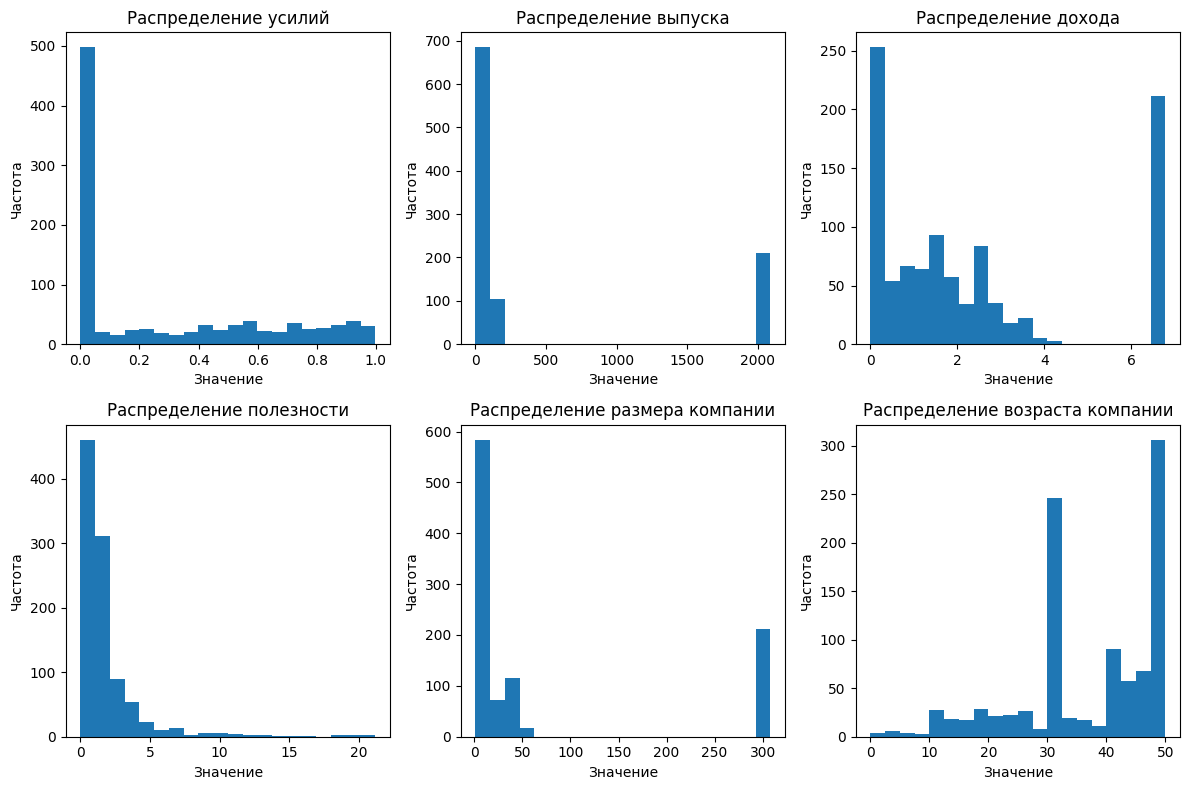

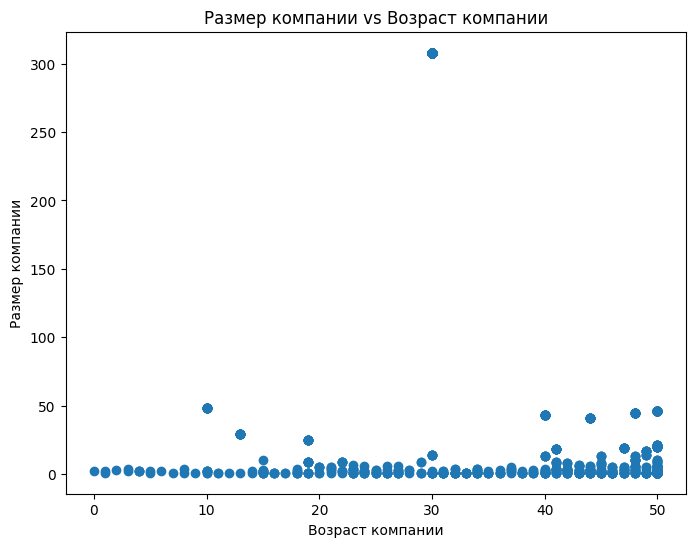

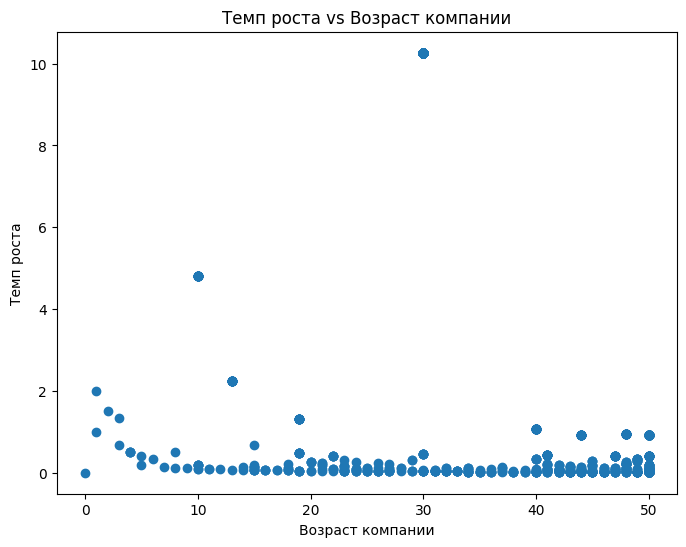


Распределения для фирм:
Выпуск - Среднее: 0.98, Медиана: 0.41, Мин: 0.00, Макс: 82.13
Размер - Среднее: 3.26, Медиана: 2.00, Мин: 1.00, Макс: 308.00
Возраст - Среднее: 36.83, Медиана: 41.00, Мин: 0.00, Макс: 50.00
Производительность - Среднее: 0.27, Медиана: 0.23, Мин: 0.00, Макс: 1.00
Темп роста - Среднее: 0.12, Медиана: 0.04, Мин: 0.00, Макс: 10.27


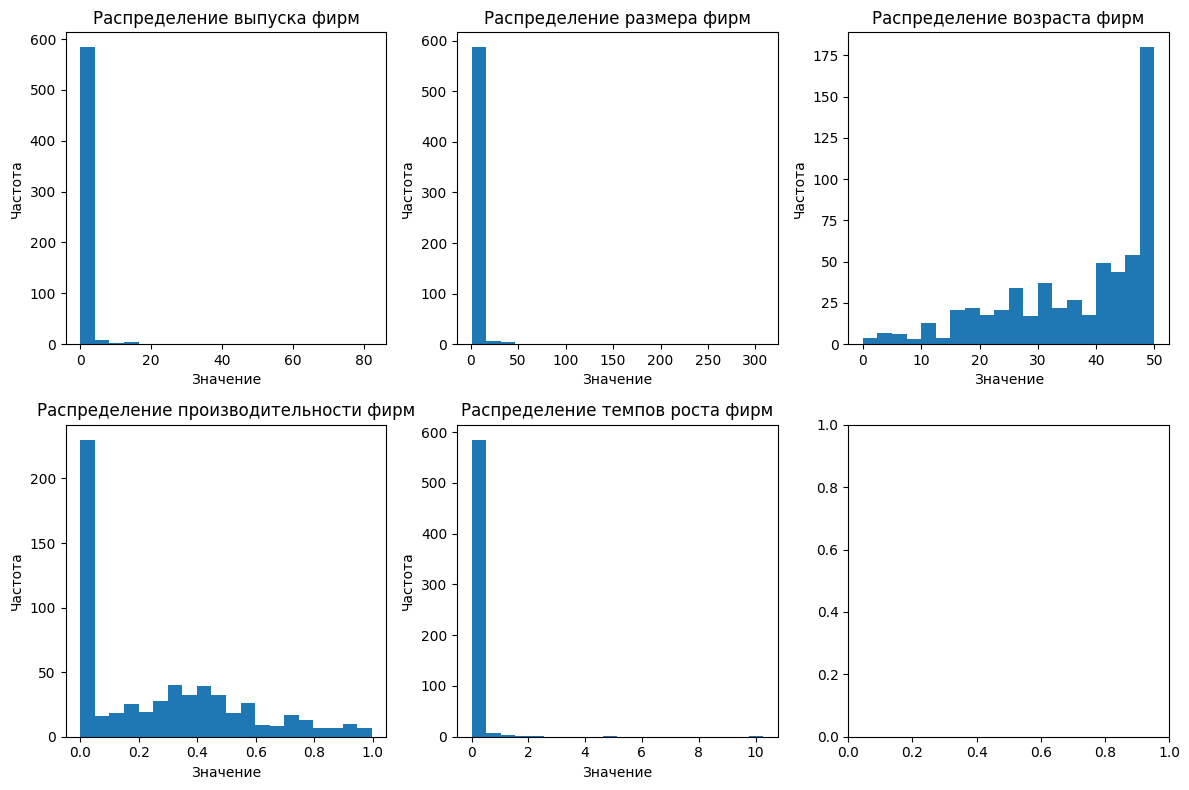

In [83]:
agent_count = 1000
period_count = 50 
# Передаём кол-во агентов, кол-во периодов, выводить ли каждый период инфо, выводить ли только в последний раз 
simulate(agent_count, period_count, False, True)
